In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [2]:
seed = 0

In [3]:
X, Y = data.load_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.Sex.values
A_test = X_test.Sex.values

## Model without fairness

I'll train the model with the base parameters of XGBoost.

In [31]:
model = models.XGBoostWrapper()
model.fit(X_train, Y_train);

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [73]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=100,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


/tmp/ipykernel_314/2047546585.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-10-19 22:14:35,986] A new study created in memory with name: no-name-ccb7d108-8fdf-4215-b643-ee3c1b1968ca
[I 2023-10-19 22:14:36,411] Trial 0 finished with value: 0.7546728488692775 and parameters: {'n_estimators': 26, 'colsample_bytree': 0.7171410857599202, 'max_depth': 10, 'l2_weight': 19.56768505212063}. Best is trial 0 with value: 0.7546728488692775.
[I 2023-10-19 22:14:36,567] Trial 1 finished with value: 0.7591267207896671 and parameters: {'n_estimators': 32, 'colsample_bytree': 0.9825239593893744, 'max_depth': 4, 'l2_weight': 70.14984882186943}. Best is trial 1 with value: 0.7591267207896671.
[I 2023-10-19 22:14:36,937] Trial 2 finished with value: 0.7592098875022982 and parameters: {'n_estimators': 44, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}

In [34]:
utils.eval_model_train_test(
    model,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.955124,0.923267,0.076733,0.313419,0.662721,0.909253,0.949109,train_g0
1,0.967223,0.870130,0.129870,0.330026,0.662721,0.882353,0.943662,train_g1
2,0.708293,0.715789,0.284211,0.537364,0.662721,0.687500,0.839506,test_g0
3,0.738723,0.808511,0.191489,0.553715,0.662721,0.722222,0.775510,test_g1


In [76]:
model_search.best_params_

{'n_estimators': 47,
 'colsample_bytree': 0.7718571788791524,
 'max_depth': 4,
 'l2_weight': 66.93644599434192}

In [77]:
best_params = {'n_estimators': 47,
 'colsample_bytree': 0.7718571788791524,
 'max_depth': 4,
 'l2_weight': 66.93644599434192}

In [75]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.885747,0.767327,0.232673,0.398956,0.723645,0.790036,0.928144,train_g0
1,0.865028,0.701299,0.298701,0.460908,0.723645,0.760504,0.907563,train_g1
2,0.761404,0.642105,0.357895,0.487278,0.723645,0.664062,0.871429,test_g0
3,0.757447,0.765957,0.234043,0.552424,0.723645,0.722222,0.800000,test_g1


## Model with dual step

In [4]:
def logloss_grad(predt, dtrain):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    return grad

def logloss_hessian(predt, dtrain):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    return hess

In [5]:
def logloss_group(predt, dtrain, subgroup):
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    loss = - (y * np.log(predt) + (1 - y) * np.log(1 - predt))
    groups = np.unique(subgroup)
    loss_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        loss_matrix[:, i] = loss # copy the column
        loss_matrix[subgroup!= group, i] = 0 # and set 0 for other groups

    loss_matrix = np.sum(loss_matrix, axis = 0)  / np.sum(loss_matrix != 0, axis = 0)
    return loss_matrix


def logloss_grad_group(predt, dtrain, subgroup):
    '''Compute the gradient for log loss for each group.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)

    groups = np.unique(subgroup)
    grad_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        grad_matrix[:, i] = grad # copy the column
        grad_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return grad_matrix


def logloss_hessian_group(predt, dtrain, subgroup):
    '''Compute the hessian for log loss for each group.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))

    groups = np.unique(subgroup)
    hess_matrix = np.zeros((len(hess), len(groups)))

    for i, group in enumerate(groups):
        hess_matrix[:, i] = hess # copy the column
        hess_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return hess_matrix

In [70]:
def penalize_max_loss_subgroups(subgroup_idx, fair_weight):
    weight_1 = 1 
    weight_2 = fair_weight 


    def custom_obj(predt, dtrain):

        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        
        if weight_2 > 0:
            # dual problem
            loss_group = logloss_group(predt, dtrain, subgroup)
            mu = cp.Variable(loss_group.shape[0]) # number of groups
            z = cp.Variable(1) # z is the min of mu * loss
            constraints = [cp.sum(mu) == weight_2, mu >= 0] + [z <= mu[i] * loss_group[i] for i in range(loss_group.shape[0])]
            objective = cp.Maximize(z)
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # primal problem
            mu_opt = mu.value
        else:
            mu_opt = np.zeros(len(np.unique(subgroup)))
            
        grad_group = logloss_grad_group(predt, dtrain, subgroup)
        hess_group = logloss_hessian_group(predt, dtrain, subgroup)
        grad = logloss_grad(predt, dtrain) * weight_1 + np.sum(mu_opt * grad_group, axis=1) 
        hess = logloss_hessian(predt, dtrain) * weight_1 + np.sum(mu_opt * hess_group, axis=1)

        return grad, hess
    return custom_obj

Train dual problem without hyperparameter selection.

In [84]:
dual_model = models.XGBoostWrapper(
    objective = penalize_max_loss_subgroups(0, 1),
    **best_params
)
dual_model.fit(X_train, Y_train);

In [85]:
utils.eval_model_train_test(
    dual_model,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.905776,0.806931,0.193069,0.374935,0.715097,0.822064,0.936782,train_g0
1,0.883581,0.720779,0.279221,0.437907,0.715097,0.764706,0.895161,train_g1
2,0.745774,0.642105,0.357895,0.497123,0.715097,0.656250,0.859155,test_g0
3,0.763404,0.765957,0.234043,0.547132,0.715097,0.722222,0.800000,test_g1


  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:21<00:00,  2.32it/s]


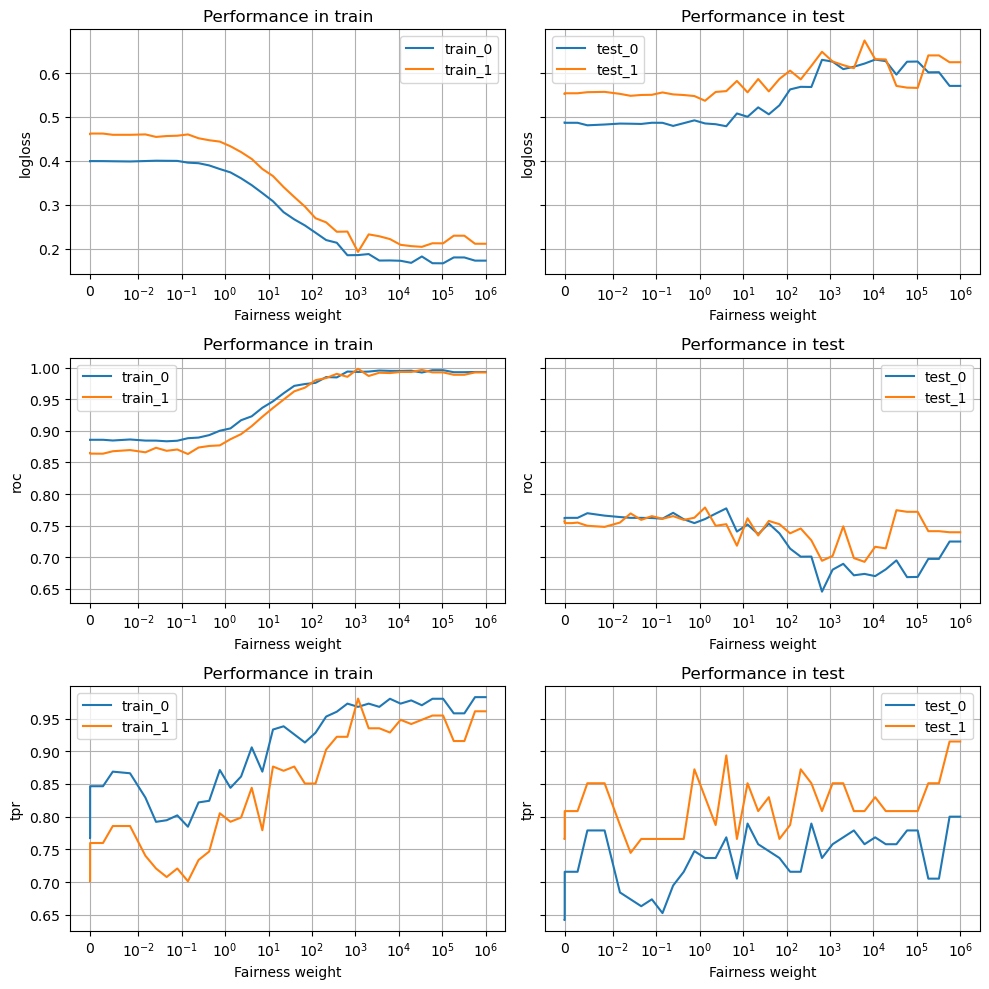

In [87]:
lambda_values = np.append([0],np.logspace(-6, 6, num=50))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        objective = penalize_max_loss_subgroups(0, lambda_value),
        **best_params
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)
utils.comparison_subgrous_metrics_lambda(results)